# Automatic Identification of Natural Disasters from Satellite Images

Local, States, National or even foreign governments need support as to implement short-term emergency response, and long-term hazard mitigation measures at the occurrences of natural disaster such as tropical cyclones, wildfires, earthquakes, etc. The sample notebook takes advantage of [NASA's Earth Observatory Natural Event Tracker (EONET) API](https://eonet.sci.gsfc.nasa.gov/eonet-project) to collect a curated source of continuously updated natural event metadata, then creates [FeatureCollection(s)](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurecollection) based on the descriptions and geo-information provided in the metadata feed for each type of the natural disasters, and saves into a Web Map item on the targeted GIS connection. 

In the meantime, with the temporal and geospatial information of the event occurrence, this sample goes on to query the before- and after- disaster satellite images of the prone areas, and add as overlay layers besides the FeatureCollection generated at the first step. The differences between the two temporal conditions can be collected for training dataset, and hence when there are sufficient of these images (or labels), we can build a model to identify from the satellite images if there is a natural disaster (e.g. tropical cyclone).

With the sample notebook run in a scheduled routine, there will be a latest web map that contains the up-to-date list of natural  disaster occurrences in your organization always.

## Step 1. Pre-requisites
In order to access the Land Remote-Sensing Satellite (System) (in short, Landsat) dataset, the first step is to connect to ArcGIS Online organization since `esri livingatlas` provided a series of good-to-use Landsat products in forms of imagery layers ready for query, visualization and analysis. Then to create another GIS class object for an ArcGIS Enterprise deployment in case that you want to save the target web map in a different destination than ArcGIS Online.

In [8]:
from arcgis.gis import GIS
gis = GIS('https://www.arcgis.com',"arcgis_python","P@ssword123")
portal_gis = GIS('https://datascienceqa.esri.com/portal','portaladmin','esri.agp')
# portal_gis = GIS('https://pythonapi.playground.esri.com/portal','arcgis_python','amazing_arcgis_123')

The `exact_search` method here is to start a search based on title, owner and item type, then use a for loop to traverse all the query results in order to get an exact match that has the desired title and item type. It can be used in place of the generic `search` method so you do not need to specify the index of the desired imagery layery among all the search results. As seen here, the output of the `exact search` is a Imagery Layer item titled `"Multispectral Landsat"`.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>
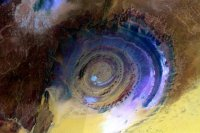

In [9]:
def exact_search(my_gis, title, owner_value, item_type_value):
    final_match = None
    search_result = my_gis.content.search(query= title + ' AND owner:' + owner_value, item_type=item_type_value, outside_org=True)
    
    if "Imagery Layer" in item_type_value:
        item_type_value = item_type_value.replace("Imagery Layer", "Image Service")
    elif "Layer" in item_type_value:
        item_type_value = item_type_value.replace("Layer", "Service")
    
    for result in search_result:
        if result.title == title:
            final_match = result
            break
    return final_match

landsat_item = exact_search(gis, 'Multispectral Landsat', 'esri', 'Imagery Layer')
landsat = landsat_item.layers[0]
landsat_item

The Python API also supports specifying Javascript renderers via `autocasting`. This Python API displays maps in a Jupyter notebook by leveraging the ArcGIS API for JavaScript. By specifying `"renderer": "autocast"` for any renderer, you are directing Python to allow the Javascript API to attempt to infer the renderer by following Javascript API rules. Besides using `add_layer(...)` method to add the newly created feature class or feature service into map view (using renderer JSON in the parameter), you can also use `draw(...)` method with symbol and pop-up specified in the arguments list. 

Renderer or Symbol JSON for different natural disasters are defined here as entries for dictionary objects (e.g. `symbol_doct` or `renderer_dict`).

Sample symbol JSONs can be generated from [Symbol Marker](http://esri.github.io/arcgis-python-api/tools/symbol).

In [10]:
# Symbol of Tropical Cyclone
symbol_storm = {"angle":0,"xoffset":0,"yoffset":0,
                "type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/OutdoorRecreation/Lightning.png",
                "contentType":"image/png",
                "width":24,"height":24
               }
renderer_storm = {"renderer": "autocast",
                  "type":"simple",
                  "symbol": symbol_storm
                 }

# Symbol of Wildfires
symbol_wildfire = { "angle":0,"xoffset":0,"yoffset":0,
                    "type":"esriPMS",
                    "url":"https://static.arcgis.com/images/Symbols/NPS/Campfire_1.png",
                    "contentType":"image/png",
                    "width":24,"height":24
                   }
renderer_wildfire = {"renderer": "autocast",
                     "type": "simple",
                     "symbol": symbol_wildfire
                    }

# Symbol of volcano eruption
symbol_volcano = { "angle":0,"xoffset":0,"yoffset":0,
                   "type":"esriPMS",
                   "url":"https://static.arcgis.com/images/Symbols/NPS/Grill.png",
                   "contentType":"image/png",
                   "width":24,"height":24
                  }
renderer_volcano = {"renderer": "autocast",
                    "type": "simple",
                    "symbol": symbol_volcano
                    }

# Symbol of Iceberg
symbol_iceberg = {"angle":0,"xoffset":0,"yoffset":0,
                  "type":"esriPMS",
                  "url":"https://static.arcgis.com/images/Symbols/NPS/Ice_1.png",
                  "contentType":"image/png",
                  "width":24,"height":24
                 }
renderer_iceberg = {"renderer": "autocast",
                    "type": "simple",
                    "symbol": symbol_iceberg
                    }

# dictionary objects
symbol_dict = {
    "Tropical Cyclone": symbol_storm,
    "Wildfires": symbol_wildfire,
    "Volcano": symbol_volcano,
    "Iceberg": symbol_iceberg
}
renderer_dict = {
    "Tropical Cyclone": renderer_storm,
    "Wildfires": renderer_wildfire,
    "Volcano": renderer_volcano,
    "Iceberg": renderer_iceberg
}

## Step 2. Define functions of your own
The sample would require three user-defined functions to: a. parse the metadata feed (in GeoJSON) and create one FeatureClass per event, and add the FeatureClass to a map, b. obtain the temporal range and the spatial boundingbox of the FeatureClass, perform `filter_by(...)` to the landsat imagery layer with the criteria, and add the before- and after- disaster imageries to the map, and c. store the current map as web map.

In the `filter_images` method defined below, given the temporal range and the spatial boundingbox of the FeatureClass, `filter_by(...)` is performed to the landsat imagery layer with the criteria, and when one or more mosiac tiles meet the requirements, get the `mean` of these tiles and add to current map.

In [11]:
import pandas as pd
import arcgis
from arcgis import geometry
from arcgis.geometry import Geometry
import datetime as dt

def filter_images(fc, my_map, start_datetime, end_datetime):
    
    geom_obj = Geometry(fc.properties.layerDefinition.extent)
    selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.2)",
                                 time=[start_datetime, end_datetime],
                                 geometry=geometry.filters.intersects(geom_obj))
    print("Applicable lockRasterIds=", selected._mosaic_rule.get("lockRasterIds"))
    
    if not selected._mosaic_rule.get("lockRasterIds"):
        return None
    else:
        date_title_from = start_datetime.strftime("%m/%d/%Y")
        date_title_to = end_datetime.strftime("%m/%d/%Y")
        extents = fc.properties.layerDefinition.extent
        extents_str = ",".join(format(x, "10.3f") for x in [extents['xmin'],extents['ymin'],extents['xmax'], extents['ymax']])

        my_map.add_layer(selected.mean(), {"title": date_title_from + " to " + date_title_to + " at [" + extents_str + "]"})

        fs = selected.query(out_fields="AcquisitionDate, GroupName, Month, DayOfYear, WRS_Row, WRS_Path")
        tdf = fs.sdf  
        print(tdf.shape)
        return tdf

Next, the `create_all_fs_from_json` method sends a request to the API's feed URL, reads the response into json object, and then has all events in the feed json traversed to check for the disaster type, geolocation and descriptions of each event. These information will be used to create a FeatureClass for each event in `portal_gis` which can be then added to the current map. When the `save_to_fc` boolean is True, the function will then save each feature class into an individual FeatureCollection item on the enterprise; when the `add_Landsat` boolean is True, the function will automatically invoke `filter_images` to get the before- and after- disaster satellite images to the map.

In [12]:
import json
import requests
import traceback
from arcgis.features import Feature, FeatureSet

def create_all_fs_from_json(url, disaster_type, add_to_map=None, 
                            use_default_symbol = True, save_to_fc = False, add_Landsat = False):
    response = requests.get(url)
    json_data = json.loads(response.text)
    item_list = []

    for event in json_data["events"]:
        if disaster_type in event["title"]:
            
            try:
                print(event["title"], event["link"])
                resp_event = requests.get(event["link"])
                json_event = json.loads(resp_event.text)
                r = json.dumps(json_event["geometries"])
                df = pd.read_json(r, orient=",")
                df[['coordinates_x', 'coordinates_y']] = pd.DataFrame(df['coordinates'].tolist(), index=df.index)
                fc = portal_gis.content.import_data(df, locationtype="coordinates",
                                        longitude_field="coordinates_x",latitude_field="coordinates_y")
                if add_to_map is not None:
                    if use_default_symbol:
                        """ Add_layer() used directly
                        # option_dict = {"title": event["title"]}
                        # option_dict.update(renderer_dict[disaster_type])
                        # add_to_map.add_layer(fc, option_dict)

                        # add_to_map.add_layer(fc, renderer_dict[disaster_type])

                        # add_to_map.add_layer(fc, {"title": event["title"], "renderer": renderer_dict[disaster_type]})
                        """
                        add_to_map.add_layer(fc, {"title": event["title"]})
                    else:
                        """ draw(...) to add sketch item to map
                        """
                        f_list = []
                        for feature in fc.properties.featureSet.features:
                            f1 = Feature(geometry={'x': feature.geometry["x"],
                                                   'y': feature.geometry["y"]})
                            f_list.append(f1)
                        fset = FeatureSet(f_list, geometry_type='esriGeometryPoint', 
                                          spatial_reference={'latestWkid': 3857})
                        add_to_map.draw(fset, symbol=symbol_dict[disaster_type], attributes={"title": event["title"]})
                    
                    print(event["title"], event["link"], "... FC Added")
                if save_to_fc:
                    item_properties = {
                        "title": json_event["title"],
                        "tags" : disaster_type,
                        "snippet": json_event["categories"][0]['title'],
                        "description": json_event["sources"][0]['url'],
                        "text": json.dumps({"featureCollection": {"layers": [dict(fc.layer)]}}),
                        "type": "Feature Collection",
                        "typeKeywords": "Data, Feature Collection, Singlelayer"
                    }
                    item = portal_gis.content.add(item_properties)
                    item_list.append(item.itemid)
                
                
                if (add_to_map is not None) and add_Landsat:
                    datetime_object = dt.datetime.strptime(json_event["geometries"][0]['date'], '%Y-%m-%dT%H:%M:%SZ')
                    start_datetime = datetime_object - dt.timedelta(days=63)
                    end_datetime = datetime_object - dt.timedelta(days=21)
                    tdf = filter_images(fc, add_to_map, start_datetime, end_datetime)
                    if tdf is not None:
                        tdf.head()
                    
                    start_datetime = datetime_object - dt.timedelta(days=21)
                    end_datetime = datetime_object + dt.timedelta(days=21)
                    tdf = filter_images(fc, add_to_map, start_datetime, end_datetime)
                    if tdf is not None:
                        tdf.head()

            except Exception:
                print(traceback.format_exc())
                print(event["title"], event["link"], "... Skipped")
    return item_list

And `create_wm_from_list(...)` can be used to create a web map from a list of FeatureCollection items.

In [13]:
from arcgis.mapping import WebMap

def create_wm_from_list(fc_list, disaster_type, wm_item = None):
    if wm_item is None:
        wm = WebMap()
    else:
        wm = WebMap(wm_item)

    for fc in fc_list:
        new_item= portal_gis.content.search(fc)[0]
        wm.add_layer(new_item, options={'title':disaster_type})

    web_map_properties = {'title':disaster_type + " WM",
                         'snippet':'This web map contains multiple '+ disaster_type + ' FS',
                         'tags':'ArcGIS Python API'}

    # Call the save() with web map item's properties.
    web_map_item = wm.save(item_properties=web_map_properties)
    return web_map_item

For example, a simple usage of `create_all_fs_from_json` is shown below to create a web map containing recent volano eruptions as FeatureCollection objects.

In [13]:
map2 = gis.map('USA')

disaster_type = "Iceberg"
save_to_fc = False # set to True, if you want to save each FeatureCollection into a Feature Layer

fc_list = create_all_fs_from_json("https://eonet.sci.gsfc.nasa.gov/api/v2.1/events", disaster_type, map2, False, save_to_fc)

web_map_properties = {'title': "Natural Disasters (" + disaster_type + ") Collection",
                      'snippet':'This web map contains multiple '+ disaster_type + ' FC',
                      'tags':'ArcGIS Python API'}

if save_to_fc:
    create_wm_from_list(fc_list, disaster_type)
else:
    map2.save(item_properties=web_map_properties)

Iceberg B38 https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4129


Internal Server Error


Traceback (most recent call last):
  File "<ipython-input-9-8b1ae623a477>", line 23, in create_all_fs_from_json
    longitude_field="coordinates_x",latitude_field="coordinates_y")
  File "E:\Repos\geosaurus\src\arcgis\gis\__init__.py", line 4004, in import_data
    res = self._portal.con.post(path, postdata)#, use_ordered_dict=True) - OrderedDict >36< PropertyMap
  File "E:\Repos\geosaurus\src\arcgis\_impl\connection.py", line 1167, in post
    self._handle_json_error(resp_json['error'], errorcode)
  File "E:\Repos\geosaurus\src\arcgis\_impl\connection.py", line 1188, in _handle_json_error
    raise RuntimeError(errormessage)
RuntimeError: Internal Server Error
(Error Code: 500)

Iceberg B38 https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4129 ... Skipped
Iceberg B39 https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4130
Iceberg B39 https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4130 ... FC Added
Iceberg B40 https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4131
Ic

A more advanced usage is to create the web map that includes recent events for a list of natural disaster types as FeatureCollection objects, and also attach the before- and after-disaster satellite images in the web map.

In [14]:
disasters = ["Tropical Cyclone", "Wildfires"] # disaster_type picked from "Tropical Cyclone", "Wildfires", "Volcano", "Iceberg"
map3 = gis.map('USA')

for disaster_type in disasters:
    fc_list = create_all_fs_from_json("https://eonet.sci.gsfc.nasa.gov/api/v2.1/events", disaster_type, map3, add_Landsat = True)

if len(disasters) > 1:
    wm_token = ", ".join(str(e) for e in disasters)
else:
    wm_token = disasters[0]
    
web_map_properties = {'title': "Natural Disasters (" + wm_token + ") Collection",
                      'snippet':'This web map contains multiple '+ disaster_type + ' FC',
                      'tags':'ArcGIS Python API'}

# Call the save() with web map item's properties.
map3.save(item_properties=web_map_properties)

Tropical Cyclone Joaninha https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4153
Tropical Cyclone Joaninha https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4153 ... FC Added
Applicable lockRasterIds= [1054701, 1066487, 1089251]
(3, 10)
Applicable lockRasterIds= [1093323, 1101511]
(2, 10)
Wildfires - Central and Northern Portugal https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4155
Wildfires - Central and Northern Portugal https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4155 ... FC Added
Applicable lockRasterIds= [1077391]
(1, 10)
Applicable lockRasterIds= []
Wildfires - Paredones, Chile https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4154
Wildfires - Paredones, Chile https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4154 ... FC Added
Applicable lockRasterIds= [1061837, 1074463, 1087880]
(3, 10)
Applicable lockRasterIds= [1097228, 1104987]
(2, 10)
Wildfires - Southern Switzerland https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4149
Wildfires - Southe

<Item title:"Natural Disasters (Tropical Cyclone, Wildfires) Collection" type:Web Map owner:portaladmin>

You can either access the web map item from the link, or simply draw the map in the current map view.

In [ ]:
# Wildfires - Esperance, Western Australia
map3.zoom = 10
map3.center = {  'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                 'x': 121.86775,
                 'y': -33.84872
              }
map3

In [ ]:
# Or Wildfires - Paredones, Chile
map3.center = {  'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                 'x': -71.90417,
                 'y': -34.64446
              }
map3

In [ ]:
# Tropical Cyclone Joaninha
map3.center = {  'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                 'x': 64.2,
                 'y': -19.2
              }
map3

In [15]:
wm_item = exact_search(portal_gis, 'Natural Disasters (Tropical Cyclone, Wildfires) Collection', '*', 'Web Map')
wm_item

<Item title:"Natural Disasters (Tropical Cyclone, Wildfires) Collection" type:Web Map owner:portaladmin>

In [16]:
from arcgis.mapping import WebMap
webmap_obj = WebMap(wm_item)
for lyr in webmap_obj.layers:
    print(lyr.title)

12/25/2018 to 01/22/2019 at [-8073775.576,-5863052.414,-8073775.576,-5863052.414]
Wildfires - Southern Chile
01/23/2019 to 02/20/2019 at [2228499.320,-3893545.380,2228499.320,-3893545.380]
Wildfires - Southwestern, South Africa 
01/23/2019 to 02/20/2019 at [19226902.075,-5057734.544,19226902.075,-5057734.544]
Wildfires - Nelson - Tasman, New Zealand
01/28/2019 to 02/25/2019 at [-8102069.650,-4637346.120,-8102069.650,-4637346.120]
12/31/2018 to 01/28/2019 at [-8102069.650,-4637346.120,-8102069.650,-4637346.120]
Wildfires - Galvarino, Chile
01/04/2019 to 02/01/2019 at [987268.074,5806712.794,987268.074,5806712.794]
Wildfires - Southern Switzerland
02/11/2019 to 03/11/2019 at [1007320.053,5188840.125,1007320.053,5188840.125]
01/14/2019 to 02/11/2019 at [1007320.053,5188840.125,1007320.053,5188840.125]
Wildfires - Corsica, France 
01/16/2019 to 02/13/2019 at [-217866.715,7083923.080,-217866.715,7083923.080]
Wildfires - Saddleworth Moor, United Kingdom 
02/15/2019 to 03/15/2019 at [2566897.

In [17]:
map_obj = portal_gis.map(wm_item)
map_obj.center = {       'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                         'x': 64.2,
                         'y': -19.2
                 }
map_obj

MapView(layout=Layout(height='400px', width='100%'))

## Conclusion

This sample showcases an automated workflow to aggregate the recent ocurrences of natural disasters from NASA's EONET API, create according FeatureCollection based on the events and add the before- and post- disaster Landsat satellite images related to the event, and save all such layers in a web map item on target enterprise.Decision makers or Emergency Response crew can take advantage of this web map to perform disaster impact analysis or other operations.